# Thin Airfoil Theory
This notebook will use thin airfoil theory to predict the circulation distribution, lift coefficient, moment coefficient at the quarter chord, and center of pressure.

The user must provide:
 - The airfoil camberline coordinates normalized by the chord length in camberline.txt (see airfoil generators notebook)
 - The desired minimum, maximum and increments for the angle of attack (minalpha, maxalpha, alphastep)
 
The outputs of this program include
 - Plots of the circulation distribution, lift coefficient, moment coefficient at the quarter chord, and center of pressure saved in the plots folder.
 - Table of the above values saved in the data folder.
 
Once those are provided you simply need to run all the cells in the notebook to generate the output. A NACA 0012 demonstration case is included by default.

Importing a few useful libraries

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

Defining a function to do numerical integration using the trapezoidal rule

In [10]:
def integrate(x, y):
    # Performs a second-order trapezoidal rule integration
    val = 0
    for i in range(0, np.shape(x)[0] - 1):
        val = val + 0.5 * (y[i] + y[i + 1]) * (x[i + 1] - x[i])

    return val

The core thin airfoil routine

In [11]:
def thin_airfoil(alpha, plotgam, x_c, theta, dz_dx):
    # Convert alpha to radians
    alpha = alpha / 180 * math.pi

    # Generate the spectral coefficient array
    A = np.zeros(math.floor(np.shape(x_c)[0] / 2))

    # Compute the integrals for each A coefficient
    A[0] = alpha - 1.0 / math.pi * integrate(theta, dz_dx)
    for i in range(1, np.shape(A)[0]):
        A[i] = 2.0 / math.pi * integrate(theta, np.multiply(dz_dx, np.cos(i * theta)))

    # Generate the gamma over U distribution to plot skipping the leading edge
    gam = np.zeros(np.shape(x_c)[0])
    for i in range(1, np.shape(x_c)[0]):
        gam[i] = A[0] * ((1 + math.cos(theta[i])) / (math.sin(theta[i])))
        for j in range(1, np.shape(A)[0]):
            gam[i] = gam[i] + A[j] * math.sin(j * theta[i])
    gam = 2 * gam

    cl = math.pi * (2 * A[0] + A[1])
    cm_c4 = math.pi / 4 * (A[2] - A[1])
    x_cp = 1 / 4 * (1 + math.pi / cl * (A[1] - A[2]))

    # Plot the gamma distribution
    plotgam.plot(x_c[1:-1, 0], gam[1:-1], label=r'$\alpha = $' + str(alpha / math.pi * 180))
    plotgam.set_xlabel('x/c')
    plotgam.set_ylabel(r'$\gamma / U_\infty$')
    plotgam.set_title(r'$\gamma / U_\infty$ Distribution')
    plotgam.set_ylim([-1, 2])
    plotgam.legend(loc="upper right", ncol=3)
    np.savetxt('data/gamma_' + str(alpha / math.pi * 180) + '.txt', np.c_[x_c[1:-1, 0], gam[1:-1]], delimiter=' ')

    return cl, cm_c4, x_cp

Define a function to call the thin-airfoil routine for a range of angles of attack

In [12]:
def sweep(minalpha, maxalpha, alphastep, plotgam):
    # Initialize plotting arrays
    alpha_plot = []
    cl_plot = []
    cm_c4_plot = []
    x_cp_plot = []

    # Start by loading the camber line points from disk
    x_c = np.loadtxt('camberline.txt')

    # Compute the corresponding theta positions
    theta = np.arccos(1 - 2 * x_c[:, 0])

    # Approximate the slope of the camber line
    dz_dx = np.zeros(np.shape(x_c)[0])
    dz_dx[0] = (x_c[1, 1] - x_c[0, 1]) / (x_c[1, 0] - x_c[0, 0])
    dz_dx[-1] = (x_c[-1, 1] - x_c[-2, 1]) / (x_c[-1, 0] - x_c[-2, 0])
    for i in range(1, np.shape(x_c)[0] - 1):
        dz_dx[i] = (x_c[i + 1, 1] - x_c[i, 1]) / (x_c[i + 1, 0] - x_c[i, 0])

    # Sweep over a range of angles of attack
    alpha = minalpha
    while alpha <= maxalpha:
        [cl, cm_c4, x_cp] = thin_airfoil(alpha, plotgam, x_c, theta, dz_dx)

        # Append data to the plotting arrays
        alpha_plot.append(alpha)
        cl_plot.append(cl)
        cm_c4_plot.append(cm_c4)
        x_cp_plot.append(x_cp)

        alpha = alpha + alphastep

    # Plot the lift, moment, and center of pressure and save data
    figure, plot = plt.subplots()
    plot.plot(alpha_plot, cl_plot, marker=".", markersize=6, label=r'$C_L$')
    plot.legend()
    plot.set_xlabel(r'$\alpha$')
    plot.set_ylabel(r'$C_L$')
    plot.set_title('Lift Curve')
    figure.savefig('plots/cl.pdf')
    np.savetxt('data/cl.txt', np.c_[alpha_plot, cl_plot], delimiter=' ')

    figure, plot = plt.subplots()
    plot.plot(alpha_plot, cm_c4_plot, marker=".", markersize=6, label=r'$C_{m,c/4}$')
    plot.legend()
    plot.set_xlabel(r'$\alpha$')
    plot.set_ylabel(r'$C_{m,c/4}$')
    plot.set_title('Quarter Chord Moment Coefficient Curve')
    figure.savefig('plots/cm_c4.pdf')
    np.savetxt('data/cm_c4.txt', np.c_[alpha_plot, cm_c4_plot], delimiter=' ')

    figure, plot = plt.subplots()
    plot.plot(alpha_plot, x_cp_plot, marker=".", markersize=6, label=r'$x_{cp}/c$')
    plot.legend()
    plot.set_xlabel(r'$\alpha$')
    plot.set_ylabel(r'$x_{cp}/c$')
    plot.set_title('Center of Pressure Curve')
    figure.savefig('plots/x_cp.pdf')
    np.savetxt('data/x_cp.txt', np.c_[alpha_plot, x_cp_plot], delimiter=' ')

Initialize some subplots

Sweep over a range of desired angles of attack and plot the performance

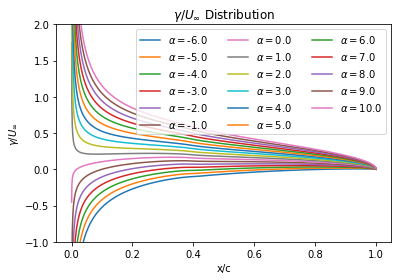

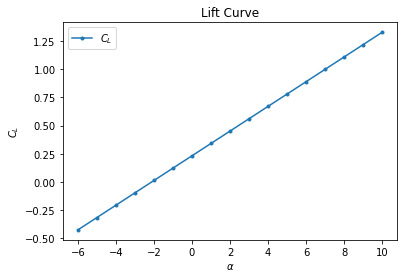

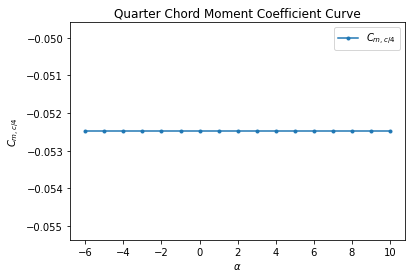

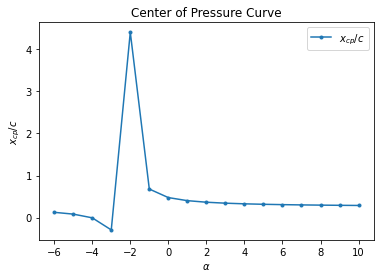

In [13]:
# Initialize the gamma plot
figgam, plotgam = plt.subplots()

# Sweep over the desired angles of attack
minalpha = -6
maxalpha = 10
alphastep = 1
sweep(minalpha, maxalpha, alphastep, plotgam)

# Show all the plots
plt.show()
figgam.savefig('plots/gamma.pdf')